In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Questions 
1. ids that have never spent more than limit
2. return users(daily basis) who spent more than limit
3. use unsupervised learning to find out unusual transactions

## Read data, merge tables

In [2]:
#read data
cc = pd.read_csv("cc_info.csv")
transaction = pd.read_csv("transactions.csv")

In [3]:
cc.head(3)

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000


In [4]:
transaction.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004


Its good to know that both tables have 984 unique credit cards

In [5]:
#check out table size
print("credit card table has shape: ", cc.shape)
print("transaction table has shape: ", transaction.shape)
print("Number of unique credit cards in cc table: {}, in transaction table: {}".format(\
                                            len(cc['credit_card'].unique()), len(transaction['credit_card'].unique())))

credit card table has shape:  (984, 5)
transaction table has shape:  (294588, 5)
Number of unique credit cards in cc table: 984, in transaction table: 984


In [6]:
#merge two tables
data = pd.merge(cc, transaction, on = 'credit_card', how = 'inner')
print("Merged table has shape: ", data.shape)
data.info()

Merged table has shape:  (294588, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 9 columns):
credit_card                  294588 non-null int64
city                         294588 non-null object
state                        294588 non-null object
zipcode                      294588 non-null int64
credit_card_limit            294588 non-null int64
date                         294588 non-null object
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: float64(3), int64(3), object(3)
memory usage: 22.5+ MB


In [7]:
#check null
data.isnull().sum()

credit_card                  0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

In [8]:
#transform date to pd.Datetime object, and create new features: month, day,hour,dayofweek
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].apply(lambda d: d.month)
data['day'] = data['date'].apply(lambda d: d.day)
data['dayofweek'] = data['date'].apply(lambda d: d.dayofweek)
data['hour'] = data['date'].apply(lambda d: d.hour)

data.drop('date', axis = 1,inplace=True)

In [9]:
data.head(3)

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,month,day,dayofweek,hour
0,1280981422329509,Dallas,PA,18612,6000,11.94,-75.964527,41.353578,8,5,2,0
1,1280981422329509,Dallas,PA,18612,6000,5.76,-76.019703,41.311467,10,29,3,18
2,1280981422329509,Dallas,PA,18612,6000,25.84,-76.043031,41.291053,10,25,6,17


**Q1. Users who never spent more than limit**

In [10]:
#group by users(credit card number)
users = data.groupby(['credit_card','month', 'credit_card_limit'])['transaction_dollar_amount'].sum().reset_index()
users = users.rename(columns = {"transaction_dollar_amount":"total_monthly_transaction_amount"})

In [11]:
users.head()

,credit_card,month,credit_card_limit,total_monthly_transaction_amount
0,1003715054175576,7,20000,162.56
1,1003715054175576,8,20000,8441.51
2,1003715054175576,9,20000,11281.56
3,1003715054175576,10,20000,8954.21
4,1013870087888817,7,15000,281.43


In [12]:
over_limit_users = users.query('total_monthly_transaction_amount > credit_card_limit')['credit_card'].unique()
clean_users = np.setdiff1d(users['credit_card'].unique(), over_limit_users)
print("There are {} users who never spent more than monthly limit".format(len(clean_users)))

There are 862 users who never spent more than monthly limit


**Q2. users(daily basis) who spent more than limit**

In [13]:
def send_warning(df, month, day):
    subdata = df[(df['month'] == month) & (df['day']<=day)]
    transaction_sum = subdata.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    limit = subdata.groupby('credit_card')['credit_card_limit'].min().reset_index()
    
    warning_df = pd.merge(transaction_sum, limit, on = 'credit_card', how='left')
    return warning_df.query('transaction_dollar_amount > credit_card_limit')

In [14]:
#example
send_warning(data, 10, 18)

,credit_card,transaction_dollar_amount,credit_card_limit
167,2505223645294729,4279.94,4000
238,3276369883343727,10795.77,10000
252,3369600965634913,2007.45,2000
285,3676109815092640,2007.41,2000
597,6292410823269309,2046.93,2000
640,6766253113444560,2842.09,2000
699,7299183791723634,7370.72,7000
798,8117664962797683,2316.71,2000
874,8972201384562696,6102.04,5000
937,9632319271199136,4459.61,4000


**Q3. unsupervised learning to find fraud transaction**

*Methods*
1. Clustering might be a good idea: fraud and nonfraud groups
2. Anomaly detection

*Anomaly types*
1. The transaction amount is way above usual transaction amount
2. The transaction location is different from usual location
3. The transaction happens at an unusual hour

Some data explorations first

In [15]:
data.head()

,credit_card,city,state,zipcode,credit_card_limit,transaction_dollar_amount,Long,Lat,month,day,dayofweek,hour
0,1280981422329509,Dallas,PA,18612,6000,11.94,-75.964527,41.353578,8,5,2,0
1,1280981422329509,Dallas,PA,18612,6000,5.76,-76.019703,41.311467,10,29,3,18
2,1280981422329509,Dallas,PA,18612,6000,25.84,-76.043031,41.291053,10,25,6,17
3,1280981422329509,Dallas,PA,18612,6000,68.89,-75.944299,41.327282,9,5,5,17
4,1280981422329509,Dallas,PA,18612,6000,27.01,-75.997259,41.352099,9,4,4,14


most transactions have dollar amount of less than 400

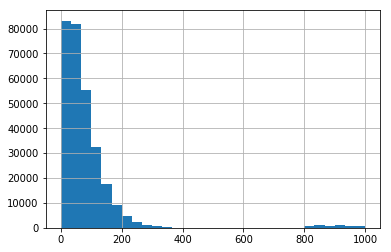

In [16]:
#distribution of transaction
data['transaction_dollar_amount'].hist(bins =  30)

We now create features based on *amount*, *location*, and *time*
1. Get the mean latitute and logitute for each user
2. Calculate distance of each transaction to (mean latitude, mean logitude)
3. Get median transaction amount. Here median is more reliable than mean because mean is likely to be affected by outliers
4. Get mean transaction hour per user and dayofweek, and subtract this mean by hour

In [17]:
#create mean latitude, longitude, and l2 distance
lat_log = data.groupby('credit_card')['Long','Lat'].mean().reset_index()
lat_log.rename(columns = {"Long": "Mean Long", "Lat":"Mean Lat"}, inplace = True)
data = pd.merge(data, lat_log, on = 'credit_card', how = 'inner')
data['dist'] = np.sqrt(np.square(data['Long'] - data['Mean Long']) + np.square(data['Lat'] - data['Mean Lat']))

In [18]:
#get median transaction amount, and rate of each transaction over median
trans = data.groupby('credit_card')['transaction_dollar_amount'].median().reset_index()
trans.rename(columns = {"transaction_dollar_amount": "median_transaction_amount"}, inplace = True)
data = pd.merge(data, trans, on = 'credit_card', how = 'inner')
data['transaction_to_median'] = data['transaction_dollar_amount'] / data['median_transaction_amount']
data['transaction_to_limit'] = data['transaction_dollar_amount'] / data['credit_card_limit']

In [19]:
time = data.groupby(['credit_card', 'dayofweek'])['hour'].mean().reset_index()
time.rename(columns={"hour":"mean_trans_hour"}, inplace = True)
data = pd.merge(data, time, on = ['credit_card', 'dayofweek'], how = 'left')
data['transaction_hour_deviation'] = data['hour'] - data['mean_trans_hour']

In [20]:
#remove some nonapplicable features
to_drop = ['city','state','zipcode','Long','Lat','month','day',\
           'dayofweek','hour','Mean Long','Mean Lat','median_transaction_amount', 'mean_trans_hour', 'credit_card_limit']
data.drop(to_drop, axis = 1, inplace = True)
data.head()

,credit_card,transaction_dollar_amount,dist,transaction_to_median,transaction_to_limit,transaction_hour_deviation
0,1280981422329509,11.94,1.009821,0.347396,0.001990,-18.027027
1,1280981422329509,5.76,1.067499,0.167588,0.000960,-0.608696
2,1280981422329509,25.84,1.092546,0.751818,0.004307,1.142857
3,1280981422329509,68.89,0.991118,2.004364,0.011482,1.500000
4,1280981422329509,27.01,1.042587,0.785860,0.004502,-1.577465


Now we have data ready. We will need to scale each column before PCA, and after scaling, we use PCA to visualize and cluster

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for col in data.columns[1:]:
    data[col] = scaler.fit_transform(data[col].reshape(-1,1))

C:\Users\sz\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


From 2d PCA plot below, it looks like there are four clusters. <br\> 
1. PC2 = 0
2. PC2 = 1.8
3. PC1 = 0
4. Between 1st PC and 2nd PC

Text(0,0.5,'2nd PCA component')

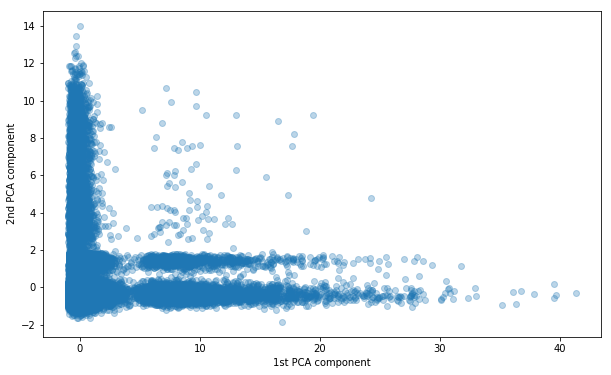

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state = 10)
new_X = pca.fit_transform(data.loc[:, data.columns != 'credit_card'])

fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(new_X[:,0], new_X[:,1], alpha = 0.3)
ax.set_xlabel("1st PCA component")
ax.set_ylabel("2nd PCA component")

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, init = "k-means++", random_state = 18, n_jobs = -1)
kmeans.fit(data.loc[:, data.columns != 'credit_card'])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=18, tol=0.0001, verbose=0)

cluster result corresponds with PCA visualization since points between PC1 and PC2 are fewest. Lets visualize data again by cluster

In [24]:
#result 
data['cluster_label'] = kmeans.labels_
data['PC1'] = new_X[:,0]
data['PC2'] = new_X[:,1]
print(data['cluster_label'].value_counts())

0    239344
2     45876
1      5445
3      3923
Name: cluster_label, dtype: int64


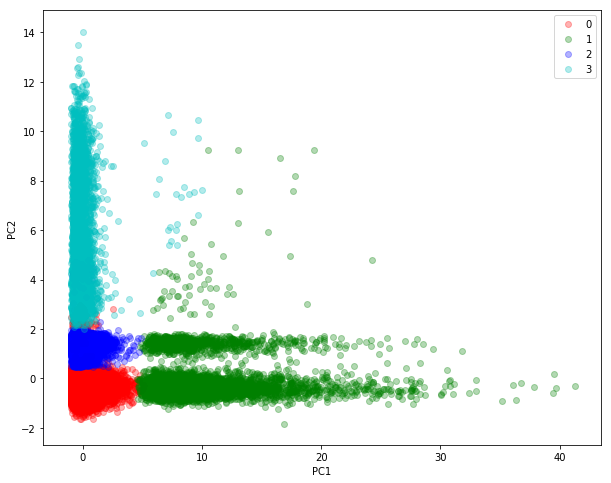

In [25]:
fig, ax = plt.subplots(figsize = (10,8))
colors = ['r','g','b','c']
for n_cluster, color in enumerate(colors):
    tmp = data[data['cluster_label'] == n_cluster]
    ax.scatter(tmp['PC1'],tmp['PC2'], label = n_cluster, color = color, alpha = 0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc = 'best')

We see that those whose distance is way different from normal transaction location fall into cluster 3. This seems reasonable because if a transaction happens very differently from a usual location, then maybe its other people using the credit card somewhere else

In [26]:
#lets take a look at cluster three elements
data.loc[data['cluster_label'] == 3, ['transaction_dollar_amount','dist','transaction_to_median', 'transaction_to_limit']].head()

,transaction_dollar_amount,dist,transaction_to_median,transaction_to_limit
45,-0.386248,6.715056,-0.077835,-0.022786
108,-0.356085,7.290577,-0.043658,0.025027
279,-0.398361,4.425915,-0.091561,-0.041988
405,0.456553,9.422864,0.132483,0.177304
422,-0.100100,12.885838,-0.136715,-0.153589
